In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

cols_cible_type = ["TurnoutTimeSeconds", "TravelTimeSeconds", "PumpSecondsOnSite"]
cols_Data = [
    ["CalYear", "HourOfCall", "Postcode_district", "Month", "DayOfWeek"],
    ["CalYear", "HourOfCall", "Postcode_district", "Month", "DayOfWeek"],
    ["CalYear", "PropertyType", "StopCode"],
]
cols_cible = [
    ["TurnoutTimeSeconds_min", "TurnoutTimeSeconds_mean", "TurnoutTimeSeconds_max"],
    ["TravelTimeSeconds_min", "TravelTimeSeconds_mean", "TravelTimeSeconds_max"],
    ["PumpSecondsOnSite_min", "PumpSecondsOnSite_mean", "PumpSecondsOnSite_max"]
    # NumPumpsAttending??
]

def load_df(col_cible_type):
    df = pd.read_csv(f"../data/_df_ready_{col_cible_type}.csv", sep=";", low_memory=False)
    # Contrôle
    # display(df.head(3))
    # display(df.info())
    return df

def load_df_full(col_cible_type):
    df = pd.read_csv(
        f"../data/_df_ready_full_{col_cible_type}.csv", sep=";", low_memory=False
    )
    # Contrôle
    # display(df.head(3))
    # display(df.info())
    return df

def Create_X(df_limited, index):    
    print(df_limited.shape)
    # Crée X sans les target
    cols_to_remove = [item for sublist in cols_cible for item in sublist] + [
        "NumPumpsAttending"
    ]
    print("cols_to_remove", cols_to_remove)
    X = df_limited.drop(cols_to_remove, axis=1)
    # Ne conserve que certaines colonnes explicatives
    # Crée une liste des colonnes à conserver
    cols_to_keep = [
        col
        for col in X.columns
        if any(substring in col for substring in cols_Data[index])
    ]
    print("cols_to_keep", cols_to_keep)
    # Conserver uniquement ces colonnes
    X = X[cols_to_keep]

    display(X.head(2))
    print(X.shape)
    return X


In [5]:
# --------------------------------------- Entraine et sauve XGBoost

import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import joblib # Pour sauvegarder l'encodeur

from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    r2_score,
)

def get_estimators(index):
    if index == 0:
        return XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            subsample=1.0,
            colsample_bytree=0.8,
            tree_method="hist",
            device="cuda",  # Utiliser le GPU
            random_state=42,
        )
    elif index == 1:
        return XGBRegressor(
            n_estimators=200,
            max_depth=7,
            learning_rate=0.1,
            subsample=1.0,
            colsample_bytree=0.8,
            tree_method="hist",
            device="cuda",  # Utiliser le GPU
            random_state=42,
        )
    else:
        return XGBRegressor(
            n_estimators=100,
            max_depth=7,
            learning_rate=0.1,
            subsample=1.0,
            colsample_bytree=0.8,
            tree_method="hist",
            device="cuda",  # Utiliser le GPU
            random_state=42,
        )


cols_cible_filter = [
    "TurnoutTimeSeconds_mean",
    "TravelTimeSeconds_mean",
    "PumpSecondsOnSite_mean",
]

results = []

for index, name in enumerate(cols_cible_type):
    df = load_df(name)

    year_floor = 13  # >= 2021
    print("-----------------------------------------------------")
    print("year", 2024 - 16 + year_floor)
    print("-----------------------------------------------------")
    df_limited = df[df.CalYear >= year_floor]

    # df_limited = df_limited.head(1000)

    X = Create_X(df_limited, index)
    for index_cible, col_cible in enumerate(cols_cible[index]):
        # if not (col_cible in cols_cible_filter):
        #     continue
        print(
            "--------------------------------------------------------------------------------"
        )
        print("///////////////////////////", "cible", col_cible)
        y = df_limited[col_cible]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        xgb = get_estimators(index)
        # Fit et Predict
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        y_train_pred = xgb.predict(X_train)
        # Sauvegarde le modèle
        joblib.dump(xgb, f"../data/_XGBoost_{col_cible}.pkl")
        # RMSE
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        print(f"RMSE train : {rmse_train}")
        rmse_test = root_mean_squared_error(y_test, y_pred)
        print(f"RMSE test : {rmse_test}")
        # MAE
        mae_train = mean_absolute_error(y_train, y_train_pred)
        print(f"MAE train : {mae_train}")
        mae_test = mean_absolute_error(y_test, y_pred)
        print(f"MAE test : {mae_test}")
        # Ajouter au tableau des résultats
        results.append(
            {
                "Target": col_cible,
                "RMSE train": rmse_train,
                "RMSE test": rmse_test,
                "MAE train": mae_train,
                "MAE test": mae_test,
            }
        )
        df_results = pd.DataFrame(results)
        df_results = df_results.sort_values(
            by=["Target", "MAE test"], ascending=[False, True]
        )
        df_results.to_csv(
            f"../data/_XGBoost_regressor_train.csv", sep=";", index=False
        )

print(results)
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Target", "MAE test"], ascending=[False, True])
df_results.to_csv(f"../data/_XGBoost_regressor_train.csv", sep=";", index=False)

-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 42)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTimeSeconds_max', 'TravelTimeSeconds_min', 'TravelTimeSeconds_mean', 'TravelTimeSeconds_max', 'PumpSecondsOnSite_min', 'PumpSecondsOnSite_mean', 'PumpSecondsOnSite_max', 'NumPumpsAttending']
cols_to_keep ['CalYear', 'HourOfCall_0', 'HourOfCall_1', 'HourOfCall_2', 'HourOfCall_3', 'HourOfCall_4', 'Postcode_district_0', 'Postcode_district_1', 'Postcode_district_2', 'Postcode_district_3', 'Postcode_district_4', 'Month_0', 'Month_1', 'Month_2', 'Month_3', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2']


,CalYear,HourOfCall_0,HourOfCall_1,HourOfCall_2,HourOfCall_3,HourOfCall_4,Postcode_district_0,Postcode_district_1,Postcode_district_2,Postcode_district_3,Postcode_district_4,Month_0,Month_1,Month_2,Month_3,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2
1147280,13,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
1147281,13,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0


(444247, 18)
--------------------------------------------------------------------------------
/////////////////////////// cible TurnoutTimeSeconds_min
RMSE train : 35.03070089957675
RMSE test : 34.74966495333391
MAE train : 23.01486040973719
MAE test : 22.8571269537776
--------------------------------------------------------------------------------
/////////////////////////// cible TurnoutTimeSeconds_mean
RMSE train : 34.60523290925957
RMSE test : 34.34307675116847
MAE train : 21.79402792252745
MAE test : 21.68069802773153
--------------------------------------------------------------------------------
/////////////////////////// cible TurnoutTimeSeconds_max
RMSE train : 41.93090947276713
RMSE test : 41.77899166344512
MAE train : 25.560251858936002
MAE test : 25.568688094483107
-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 45)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTim

,CalYear,HourOfCall_0,HourOfCall_1,HourOfCall_2,HourOfCall_3,HourOfCall_4,Postcode_district_0,Postcode_district_1,Postcode_district_2,Postcode_district_3,Postcode_district_4,Postcode_district_5,Postcode_district_6,Postcode_district_7,Postcode_district_8,Month_0,Month_1,Month_2,Month_3,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2
1147280,13,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
1147281,13,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0


(444247, 22)
--------------------------------------------------------------------------------
/////////////////////////// cible TravelTimeSeconds_min
RMSE train : 121.57526144389684
RMSE test : 123.23475900706505
MAE train : 87.0049662507445
MAE test : 88.33589764373384
--------------------------------------------------------------------------------
/////////////////////////// cible TravelTimeSeconds_mean
RMSE train : 125.21867682960033
RMSE test : 126.90122305277845
MAE train : 91.0347984569704
MAE test : 92.45491234534097
--------------------------------------------------------------------------------
/////////////////////////// cible TravelTimeSeconds_max
RMSE train : 148.2965949730331
RMSE test : 150.58593540148954
MAE train : 109.34973173868387
MAE test : 111.05293061333154
-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 40)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTi

,CalYear,PropertyType_0,PropertyType_1,PropertyType_2,PropertyType_3,PropertyType_4,PropertyType_5,PropertyType_6,StopCode_0,StopCode_1,StopCode_2,StopCode_3,StopCode_4
1147280,13,0,0,0,0,0,1,0,0,0,0,1,1
1147281,13,0,0,0,0,0,1,0,0,0,0,1,0


(444247, 13)
--------------------------------------------------------------------------------
/////////////////////////// cible PumpSecondsOnSite_min
RMSE train : 1256.8560222140006
RMSE test : 1254.2291688361586
MAE train : 687.5847675278394
MAE test : 688.45555503008
--------------------------------------------------------------------------------
/////////////////////////// cible PumpSecondsOnSite_mean
RMSE train : 1304.5498053551696
RMSE test : 1299.91540632567
MAE train : 712.6486377182979
MAE test : 712.675863346922
--------------------------------------------------------------------------------
/////////////////////////// cible PumpSecondsOnSite_max
RMSE train : 1456.1206782415604
RMSE test : 1454.107551176995
MAE train : 789.7009557290367
MAE test : 790.7748800592202
[{'Target': 'TurnoutTimeSeconds_min', 'RMSE train': np.float64(35.03070089957675), 'RMSE test': np.float64(34.74966495333391), 'MAE train': np.float64(23.01486040973719), 'MAE test': np.float64(22.8571269537776)}, {

In [7]:
# --------------------------------------- Test avec Reload XGBoost

import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import joblib  # Pour sauvegarder l'encodeur

from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
)

cols_cible_filter = [
    "TurnoutTimeSeconds_mean",
    "TravelTimeSeconds_mean",
    "PumpSecondsOnSite_mean",
]

results = []

for index, name in enumerate(cols_cible_type):
    df = load_df(name)

    year_floor = 13  # >= 2022
    print("-----------------------------------------------------")
    print("year", 2024 - 16 + year_floor)
    print("-----------------------------------------------------")
    df_limited = df[df.CalYear >= year_floor]

    # df_limited = df_limited.head(1000)

    X = Create_X(df_limited, index)
    for index_cible, col_cible in enumerate(cols_cible[index]):
        # if not (col_cible in cols_cible_filter):
        #     continue
        print(
            "--------------------------------------------------------------------------------"
        )
        print("///////////////////////////", "cible", col_cible)
        y = df_limited[col_cible]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        # Charge le modèle
        xgb = joblib.load(f"../data/_XGBoost_{col_cible}.pkl")
        # Predict
        y_pred = xgb.predict(X_test)
        y_train_pred = xgb.predict(X_train)
        # RMSE
        rmse_train = root_mean_squared_error(y_train, y_train_pred)
        print(f"RMSE train : {rmse_train}")
        rmse_test = root_mean_squared_error(y_test, y_pred)
        print(f"RMSE test : {rmse_test}")
        # MAE
        mae_train = mean_absolute_error(y_train, y_train_pred)
        print(f"MAE train : {mae_train}")
        mae_test = mean_absolute_error(y_test, y_pred)
        print(f"MAE test : {mae_test}")
        # Ajouter au tableau des résultats
        results.append(
            {
                "Target": "_" + col_cible,
                "RMSE train": rmse_train,
                "RMSE test": rmse_test,
                "MAE train": mae_train,
                "MAE test": mae_test,
            }
        )
        df_results = pd.DataFrame(results)
        df_results = df_results.sort_values(
            by=["Target", "MAE test"], ascending=[False, True]
        )
        df_results.to_csv(f"../data/_XGBoost_regressor_validate.csv", sep=";", index=False)

print(results)
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Target", "MAE test"], ascending=[False, True])
df_results.to_csv(f"../data/_XGBoost_regressor_validate.csv", sep=";", index=False)

-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 42)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTimeSeconds_max', 'TravelTimeSeconds_min', 'TravelTimeSeconds_mean', 'TravelTimeSeconds_max', 'PumpSecondsOnSite_min', 'PumpSecondsOnSite_mean', 'PumpSecondsOnSite_max', 'NumPumpsAttending']
cols_to_keep ['CalYear', 'HourOfCall_0', 'HourOfCall_1', 'HourOfCall_2', 'HourOfCall_3', 'HourOfCall_4', 'Postcode_district_0', 'Postcode_district_1', 'Postcode_district_2', 'Postcode_district_3', 'Postcode_district_4', 'Month_0', 'Month_1', 'Month_2', 'Month_3', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2']


,CalYear,HourOfCall_0,HourOfCall_1,HourOfCall_2,HourOfCall_3,HourOfCall_4,Postcode_district_0,Postcode_district_1,Postcode_district_2,Postcode_district_3,Postcode_district_4,Month_0,Month_1,Month_2,Month_3,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2
1147280,13,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
1147281,13,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0


(444247, 18)
--------------------------------------------------------------------------------
/////////////////////////// cible TurnoutTimeSeconds_min
RMSE train : 35.03070089957675
RMSE test : 34.74966495333391
MAE train : 23.01486040973719
MAE test : 22.8571269537776
--------------------------------------------------------------------------------
/////////////////////////// cible TurnoutTimeSeconds_mean
RMSE train : 34.60523290925957
RMSE test : 34.34307675116847
MAE train : 21.79402792252745
MAE test : 21.68069802773153
--------------------------------------------------------------------------------
/////////////////////////// cible TurnoutTimeSeconds_max
RMSE train : 41.93090947276713
RMSE test : 41.77899166344512
MAE train : 25.560251858936002
MAE test : 25.568688094483107
-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 45)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTim

,CalYear,HourOfCall_0,HourOfCall_1,HourOfCall_2,HourOfCall_3,HourOfCall_4,Postcode_district_0,Postcode_district_1,Postcode_district_2,Postcode_district_3,Postcode_district_4,Postcode_district_5,Postcode_district_6,Postcode_district_7,Postcode_district_8,Month_0,Month_1,Month_2,Month_3,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2
1147280,13,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
1147281,13,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0


(444247, 22)
--------------------------------------------------------------------------------
/////////////////////////// cible TravelTimeSeconds_min
RMSE train : 121.57526144389684
RMSE test : 123.23475900706505
MAE train : 87.0049662507445
MAE test : 88.33589764373384
--------------------------------------------------------------------------------
/////////////////////////// cible TravelTimeSeconds_mean
RMSE train : 125.21867682960033
RMSE test : 126.90122305277845
MAE train : 91.0347984569704
MAE test : 92.45491234534097
--------------------------------------------------------------------------------
/////////////////////////// cible TravelTimeSeconds_max
RMSE train : 148.2965949730331
RMSE test : 150.58593540148954
MAE train : 109.34973173868387
MAE test : 111.05293061333154
-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 40)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTi

,CalYear,PropertyType_0,PropertyType_1,PropertyType_2,PropertyType_3,PropertyType_4,PropertyType_5,PropertyType_6,StopCode_0,StopCode_1,StopCode_2,StopCode_3,StopCode_4
1147280,13,0,0,0,0,0,1,0,0,0,0,1,1
1147281,13,0,0,0,0,0,1,0,0,0,0,1,0


(444247, 13)
--------------------------------------------------------------------------------
/////////////////////////// cible PumpSecondsOnSite_min
RMSE train : 1256.8560222140006
RMSE test : 1254.2291688361586
MAE train : 687.5847675278394
MAE test : 688.45555503008
--------------------------------------------------------------------------------
/////////////////////////// cible PumpSecondsOnSite_mean
RMSE train : 1304.5498053551696
RMSE test : 1299.91540632567
MAE train : 712.6486377182979
MAE test : 712.675863346922
--------------------------------------------------------------------------------
/////////////////////////// cible PumpSecondsOnSite_max
RMSE train : 1456.1206782415604
RMSE test : 1454.107551176995
MAE train : 789.7009557290367
MAE test : 790.7748800592202
[{'Target': '_TurnoutTimeSeconds_min', 'RMSE train': np.float64(35.03070089957675), 'RMSE test': np.float64(34.74966495333391), 'MAE train': np.float64(23.01486040973719), 'MAE test': np.float64(22.8571269537776)}, 

-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 42)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTimeSeconds_max', 'TravelTimeSeconds_min', 'TravelTimeSeconds_mean', 'TravelTimeSeconds_max', 'PumpSecondsOnSite_min', 'PumpSecondsOnSite_mean', 'PumpSecondsOnSite_max', 'NumPumpsAttending']
cols_to_keep ['CalYear', 'HourOfCall_0', 'HourOfCall_1', 'HourOfCall_2', 'HourOfCall_3', 'HourOfCall_4', 'Postcode_district_0', 'Postcode_district_1', 'Postcode_district_2', 'Postcode_district_3', 'Postcode_district_4', 'Month_0', 'Month_1', 'Month_2', 'Month_3', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2']


,CalYear,HourOfCall_0,HourOfCall_1,HourOfCall_2,HourOfCall_3,HourOfCall_4,Postcode_district_0,Postcode_district_1,Postcode_district_2,Postcode_district_3,Postcode_district_4,Month_0,Month_1,Month_2,Month_3,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2
1147280,13,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
1147281,13,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0


(444247, 18)
--------------------------------------------------------------------------------
/////////////////////////// cible TurnoutTimeSeconds_mean


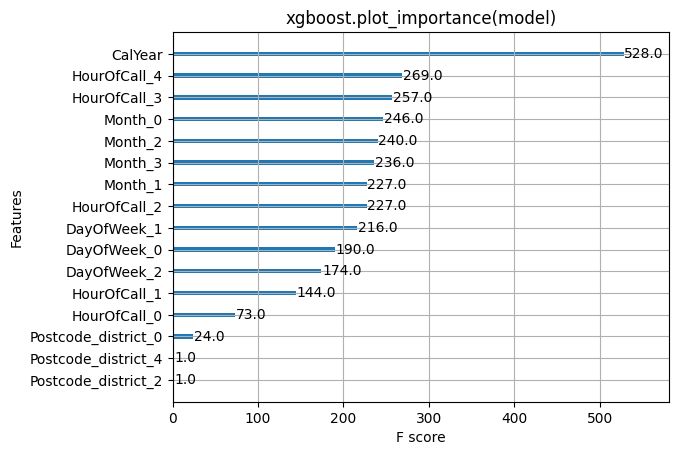

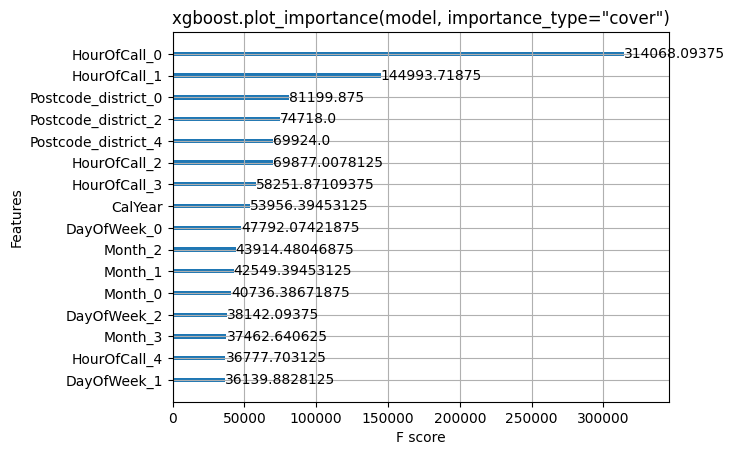

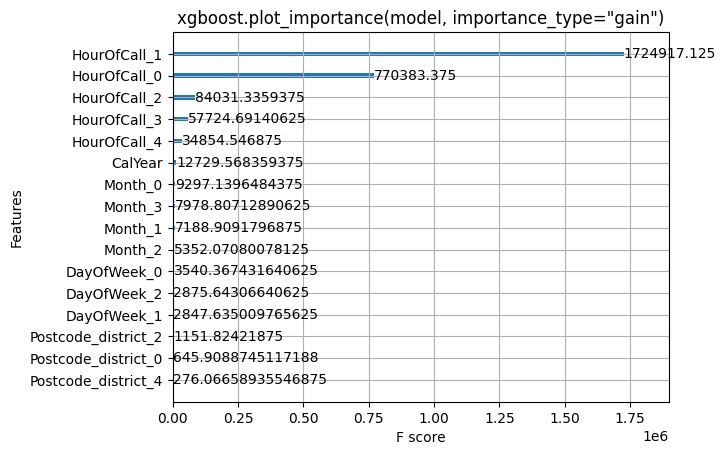

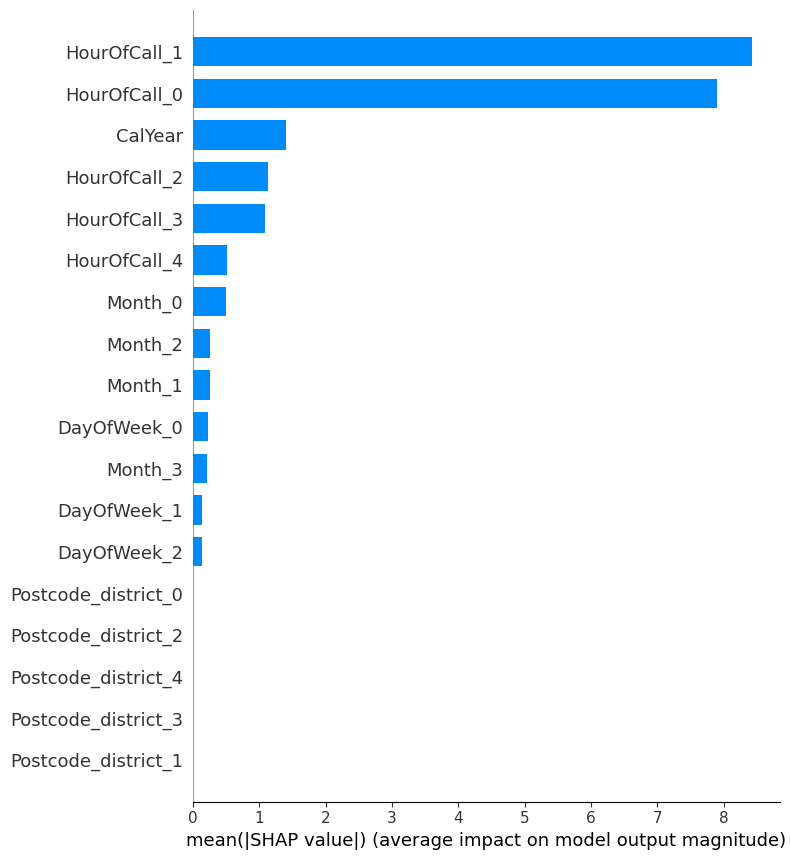

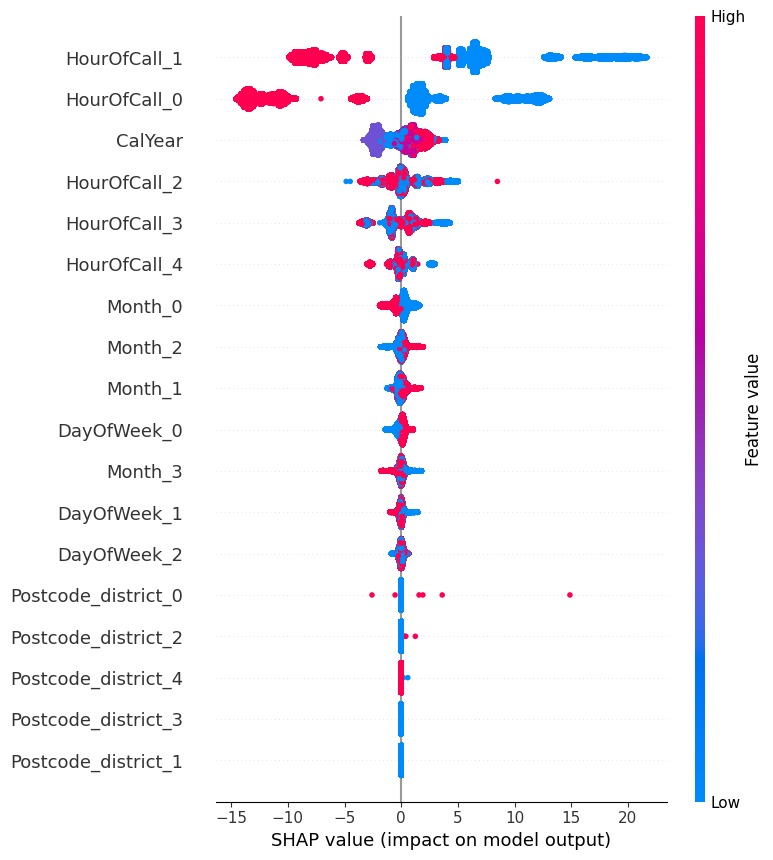

-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 45)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTimeSeconds_max', 'TravelTimeSeconds_min', 'TravelTimeSeconds_mean', 'TravelTimeSeconds_max', 'PumpSecondsOnSite_min', 'PumpSecondsOnSite_mean', 'PumpSecondsOnSite_max', 'NumPumpsAttending']
cols_to_keep ['CalYear', 'HourOfCall_0', 'HourOfCall_1', 'HourOfCall_2', 'HourOfCall_3', 'HourOfCall_4', 'Postcode_district_0', 'Postcode_district_1', 'Postcode_district_2', 'Postcode_district_3', 'Postcode_district_4', 'Postcode_district_5', 'Postcode_district_6', 'Postcode_district_7', 'Postcode_district_8', 'Month_0', 'Month_1', 'Month_2', 'Month_3', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2']


,CalYear,HourOfCall_0,HourOfCall_1,HourOfCall_2,HourOfCall_3,HourOfCall_4,Postcode_district_0,Postcode_district_1,Postcode_district_2,Postcode_district_3,Postcode_district_4,Postcode_district_5,Postcode_district_6,Postcode_district_7,Postcode_district_8,Month_0,Month_1,Month_2,Month_3,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2
1147280,13,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,1,0,1,0
1147281,13,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0


(444247, 22)
--------------------------------------------------------------------------------
/////////////////////////// cible TravelTimeSeconds_mean


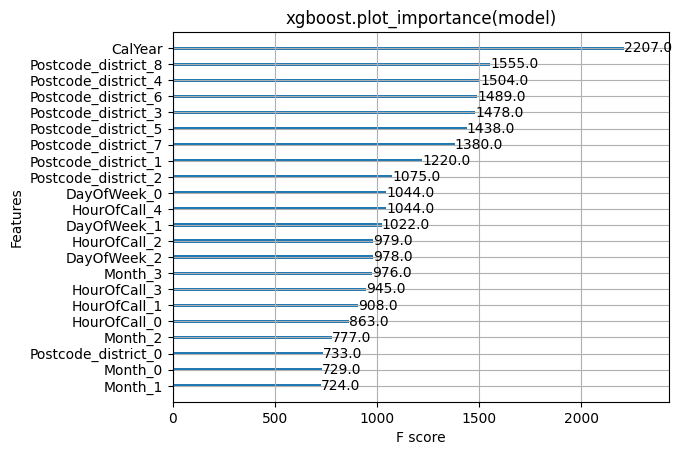

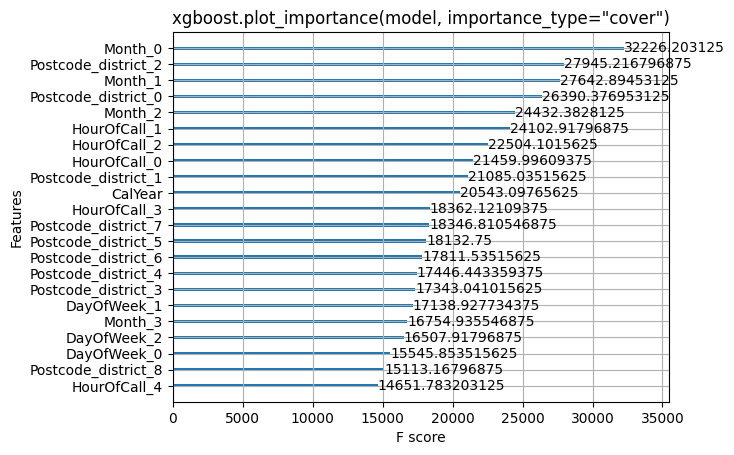

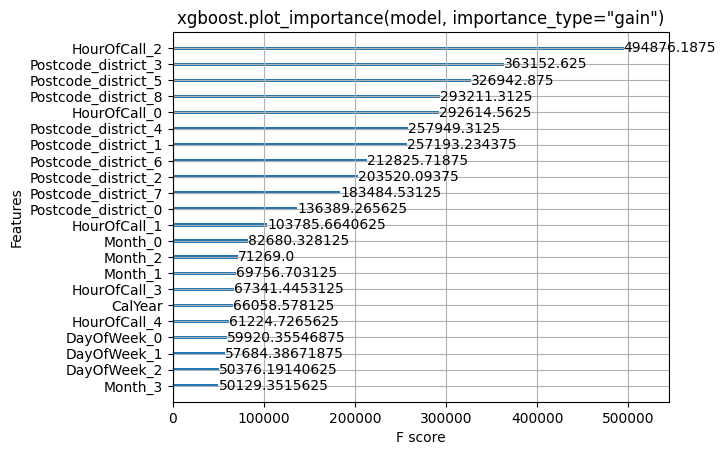

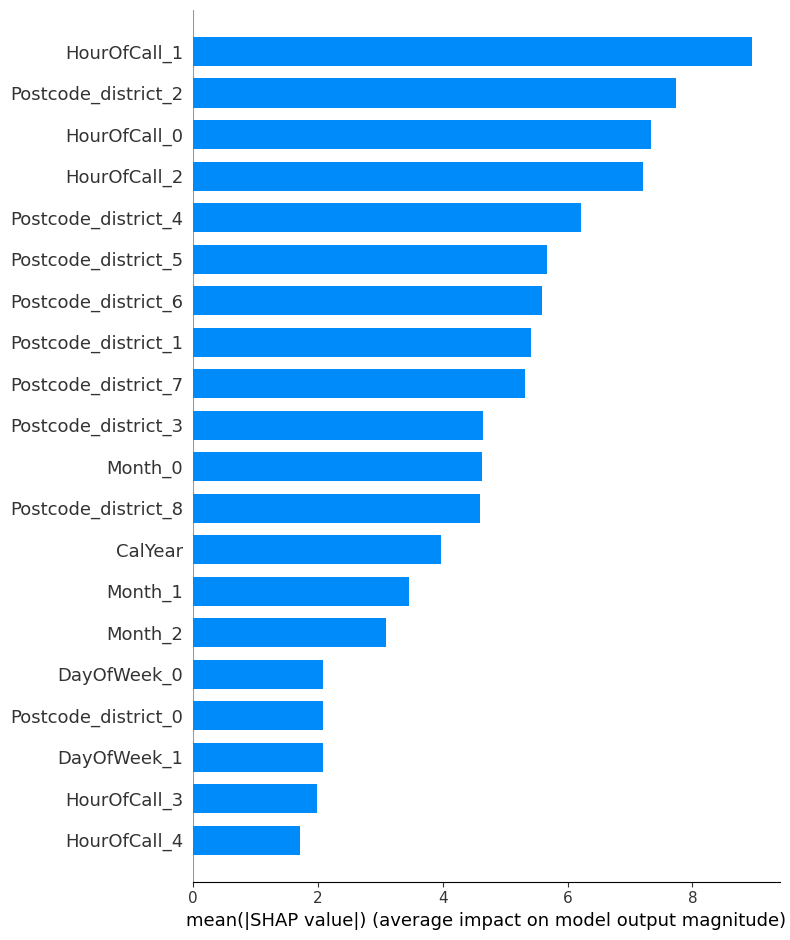

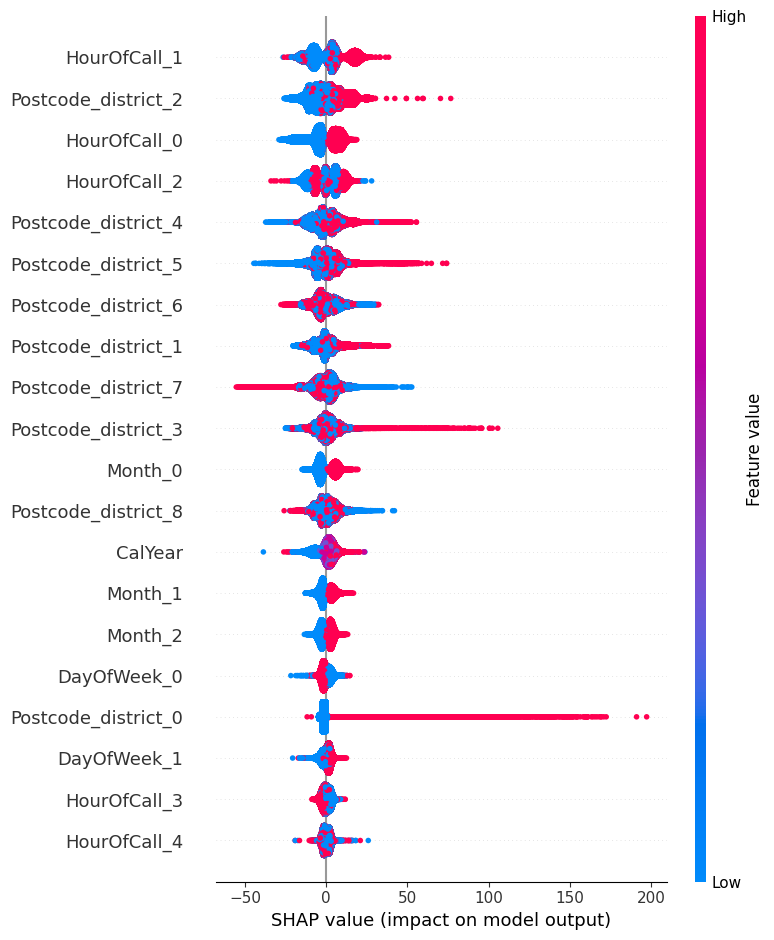

-----------------------------------------------------
year 2021
-----------------------------------------------------
(444247, 40)
cols_to_remove ['TurnoutTimeSeconds_min', 'TurnoutTimeSeconds_mean', 'TurnoutTimeSeconds_max', 'TravelTimeSeconds_min', 'TravelTimeSeconds_mean', 'TravelTimeSeconds_max', 'PumpSecondsOnSite_min', 'PumpSecondsOnSite_mean', 'PumpSecondsOnSite_max', 'NumPumpsAttending']
cols_to_keep ['CalYear', 'PropertyType_0', 'PropertyType_1', 'PropertyType_2', 'PropertyType_3', 'PropertyType_4', 'PropertyType_5', 'PropertyType_6', 'StopCode_0', 'StopCode_1', 'StopCode_2', 'StopCode_3', 'StopCode_4']


,CalYear,PropertyType_0,PropertyType_1,PropertyType_2,PropertyType_3,PropertyType_4,PropertyType_5,PropertyType_6,StopCode_0,StopCode_1,StopCode_2,StopCode_3,StopCode_4
1147280,13,0,0,0,0,0,1,0,0,0,0,1,1
1147281,13,0,0,0,0,0,1,0,0,0,0,1,0


(444247, 13)
--------------------------------------------------------------------------------
/////////////////////////// cible PumpSecondsOnSite_mean


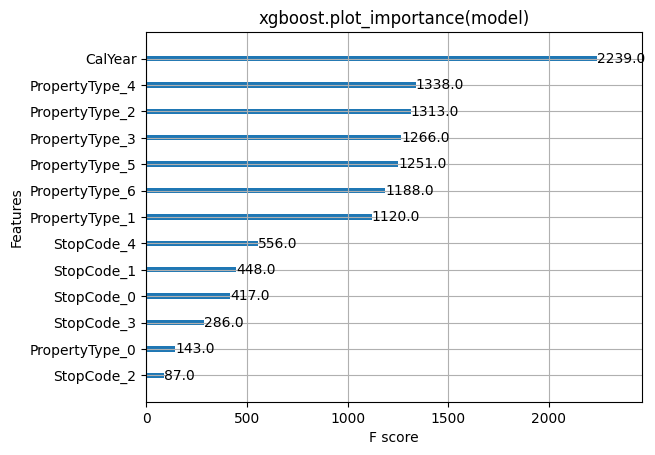

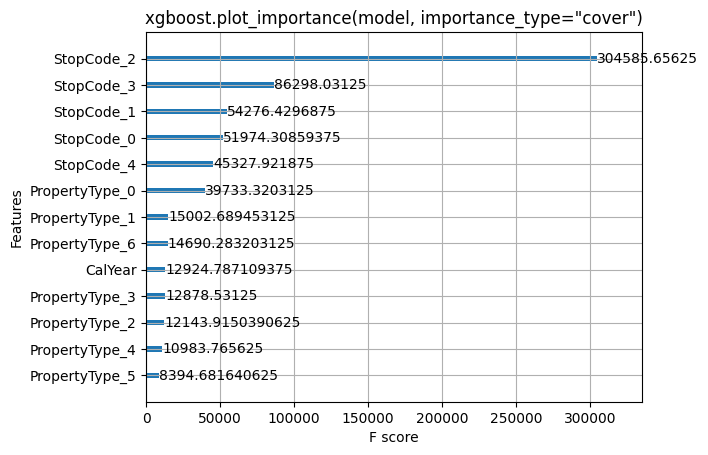

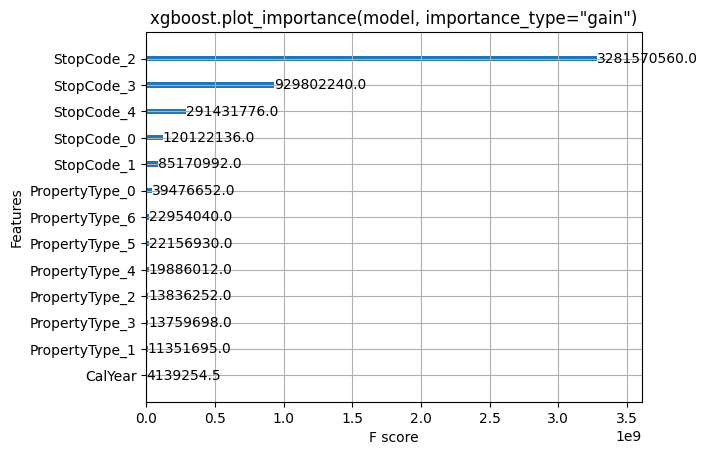

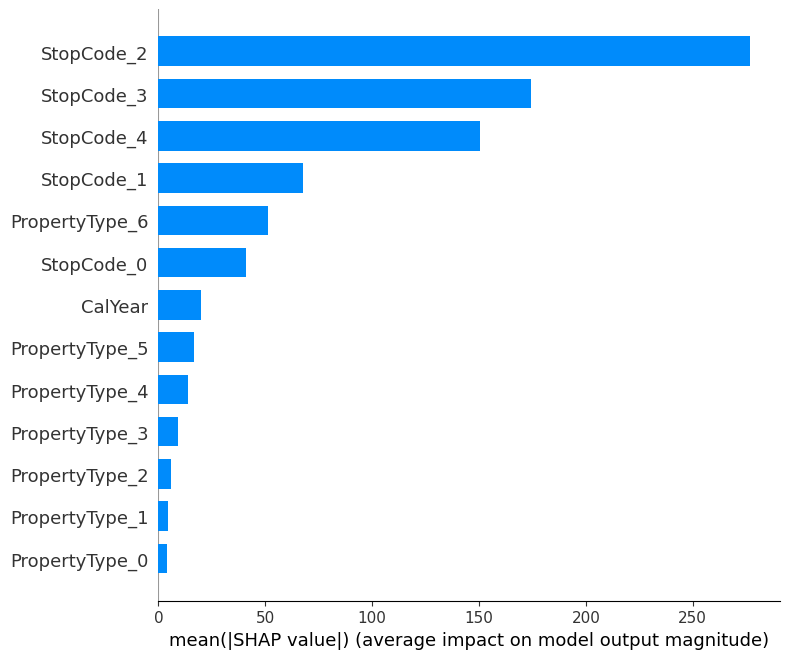

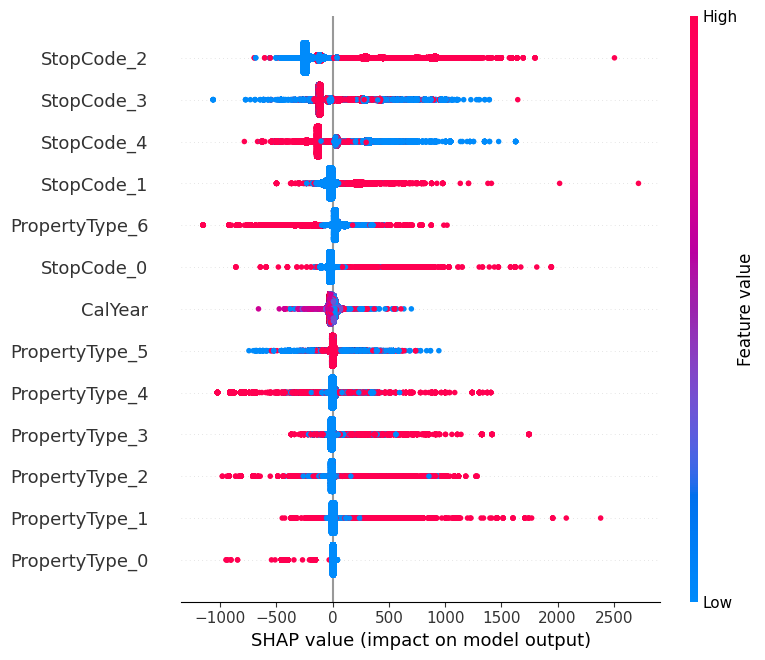

In [13]:
# --------------------------------------- Interprétabilité avec SHAP (valeurs de Shapley) XGBoost

import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import xgboost
import joblib  # Pour sauvegarder l'encodeur

from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
)

import shap
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline


cols_cible_filter = [
    "TurnoutTimeSeconds_mean",
    "TravelTimeSeconds_mean",
    "PumpSecondsOnSite_mean",
]

results = []

for index, name in enumerate(cols_cible_type):
    df = load_df(name)

    year_floor = 13  # >= 2022
    print("-----------------------------------------------------")
    print("year", 2024 - 16 + year_floor)
    print("-----------------------------------------------------")
    df_limited = df[df.CalYear >= year_floor]

    # df_limited = df_limited.head(1000)

    X = Create_X(df_limited, index)
    for index_cible, col_cible in enumerate(cols_cible[index]):
        if not (col_cible in cols_cible_filter):
            continue
        print(
            "--------------------------------------------------------------------------------"
        )
        print("///////////////////////////", "cible", col_cible)
        y = df_limited[col_cible]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        # Charge le modèle
        xgb = joblib.load(f"../data/_XGBoost_{col_cible}.pkl")
        # Predict
        y_pred = xgb.predict(X_test)
        y_train_pred = xgb.predict(X_train)
        # Shap
        explainer = shap.TreeExplainer(xgb)
        shap_values = explainer.shap_values(X)
        #
        xgboost.plot_importance(xgb)
        plt.title("xgboost.plot_importance(model)")
        plt.show()
        xgboost.plot_importance(xgb, importance_type="cover")
        plt.title('xgboost.plot_importance(model, importance_type="cover")')
        plt.show()
        xgboost.plot_importance(xgb, importance_type="gain")
        plt.title('xgboost.plot_importance(model, importance_type="gain")')
        plt.show()
        # graph à barre
        shap.summary_plot(shap_values, X, plot_type='bar')
        # 
        shap.summary_plot(shap_values, X)
        # shap.dependence_plot('Age', shap_values, X, interaction_index='Pclass')
        #
        display(shap.force_plot(explainer.expected_value, shap_values[1, :], X.iloc[1, :]))
        display(shap.force_plot(explainer.expected_value, shap_values[2000,:], X_test.iloc[2000,:]))
        #
        display(shap.force_plot(explainer.expected_value, shap_values[:120], X_test[:120]))

        
        # Ajouter au tableau des résultats
        # results.append(
        #     {
        #         "Target": "_" + col_cible,
        #         "RMSE train": rmse_train,
        #         "RMSE test": rmse_test,
        #         "MAE train": mae_train,
        #         "MAE test": mae_test,
        #     }
        # )
        # df_results = pd.DataFrame(results)
        # df_results = df_results.sort_values(
        #     by=["Target", "MAE test"], ascending=[False, True]
        # )
        # df_results.to_csv(f"../data/_XGBoost_regressor_validate.csv", sep=";", index=False)

# print(results)
# df_results = pd.DataFrame(results)
# df_results = df_results.sort_values(by=["Target", "MAE test"], ascending=[False, True])
# df_results.to_csv(f"../data/_XGBoost_regressor_validate.csv", sep=";", index=False)